# Petru și Lupul: Mediu Realist

În situația noastră, Petru a reușit să se deplaseze aproape fără să obosească sau să îi fie foame. Într-o lume mai realistă, el ar trebui să se așeze și să se odihnească din când în când, precum și să se hrănească. Haideți să facem lumea noastră mai realistă, implementând următoarele reguli:

1. Deplasându-se dintr-un loc în altul, Petru pierde **energie** și acumulează **oboseală**.
2. Petru poate recâștiga energie mâncând mere.
3. Petru poate scăpa de oboseală odihnindu-se sub un copac sau pe iarbă (adică mergând într-o locație de pe tablă care are un copac sau iarbă - câmp verde).
4. Petru trebuie să găsească și să omoare lupul.
5. Pentru a omorî lupul, Petru trebuie să aibă anumite niveluri de energie și oboseală, altfel pierde lupta.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

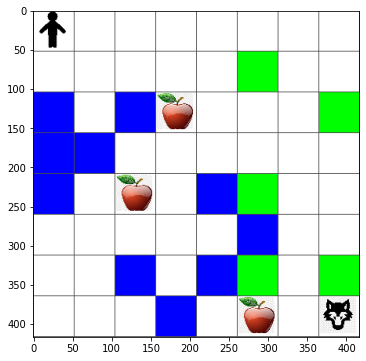

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definirea stării

În noile reguli ale jocului, trebuie să urmărim energia și oboseala în fiecare stare a tablei. Astfel, vom crea un obiect `state` care va conține toate informațiile necesare despre starea actuală a problemei, inclusiv starea tablei, nivelurile curente de energie și oboseală, și dacă putem învinge lupul în starea terminală:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Funcția de Recompensă



In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritmul Q-Learning

Algoritmul de învățare propriu-zis rămâne aproape neschimbat, folosim doar `state` în loc de simpla poziție pe tablă.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

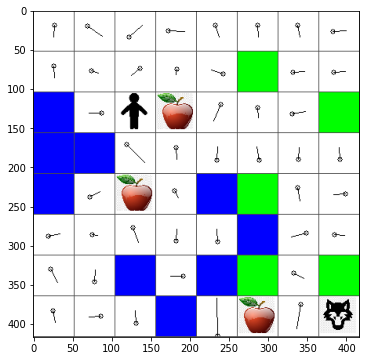

In [11]:
m.plot(Q)

## Rezultate

Să vedem dacă am reușit să-l antrenăm pe Peter să lupte cu lupul!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Vedem acum mult mai puține cazuri de înec, dar Peter încă nu reușește întotdeauna să omoare lupul. Încearcă să experimentezi și vezi dacă poți îmbunătăți acest rezultat jucându-te cu hiperparametrii.


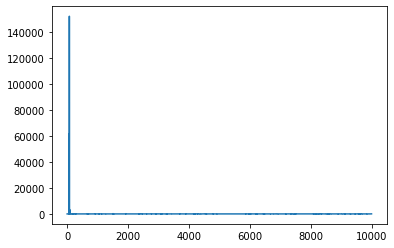

In [13]:
plt.plot(lpath)


---

**Declinarea responsabilității**:  
Acest document a fost tradus folosind serviciul de traducere AI [Co-op Translator](https://github.com/Azure/co-op-translator). Deși ne străduim să asigurăm acuratețea, vă rugăm să rețineți că traducerile automate pot conține erori sau inexactități. Documentul original în limba sa natală ar trebui considerat sursa autoritară. Pentru informații critice, se recomandă traducerea profesională realizată de un specialist uman. Nu ne asumăm răspunderea pentru eventualele neînțelegeri sau interpretări greșite care pot apărea din utilizarea acestei traduceri.
